In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pywt
import seaborn as sns

from numba import cuda

In [2]:
pd.__version__

'0.24.2'

# Import data

In [74]:
data = pd.read_csv('SP-280-Leste.csv', sep=',',header=None)
data.head()

0                 1   2     3
0  1  01/09/2011 00:00  37  89.0
1  2  01/09/2011 00:05  48  82.0
2  3  01/09/2011 00:10  26  85.0
3  4  01/09/2011 00:15  47  81.0
4  5  01/09/2011 00:20  52  82.0

## Clean and organize dataset

### Organize the dataset

Organize the columns, remove some not useful data, rename the columns and convert each column to your correct unit.

### Date-time columns

Working with date-time date requires to change the index DataFrame to the column that contain Date-Time values


In [75]:
'''Organize'''
# Drop the column '0'
data = data.drop(columns=0)

# Rename columns
data = data.rename(columns={0:"ID", 1:"Data-Hora",2:"Fluxo[veic/h.faixa]", 3:"Velocidade[km/h]" })

# Calculate flow rate
data["Fluxo[veic/h.faixa]"] = data["Fluxo[veic/h.faixa]"] * 60 / 5 / 2 # two lanes

# Calculate Density
data["Densidade[veic/km.faixa]"] = data["Fluxo[veic/h.faixa]"] / data['Velocidade[km/h]']

# Convert to_datetime
data['Data-Hora'] = pd.to_datetime(data['Data-Hora'], format='%d/%m/%Y %H:%M')

'''Date-time column index'''
data.set_index('Data-Hora',inplace=True)
data.head()

Fluxo[veic/h.faixa]  Velocidade[km/h]  \
Data-Hora                                                    
2011-09-01 00:00:00                222.0              89.0   
2011-09-01 00:05:00                288.0              82.0   
2011-09-01 00:10:00                156.0              85.0   
2011-09-01 00:15:00                282.0              81.0   
2011-09-01 00:20:00                312.0              82.0   

                     Densidade[veic/km.faixa]  
Data-Hora                                      
2011-09-01 00:00:00                  2.494382  
2011-09-01 00:05:00                  3.512195  
2011-09-01 00:10:00                  1.835294  
2011-09-01 00:15:00                  3.481481  
2011-09-01 00:20:00                  3.804878

In [76]:
data.diff()

print(data.dtypes)
print(data.shape)

Fluxo[veic/h.faixa]         float64
Velocidade[km/h]            float64
Densidade[veic/km.faixa]    float64
dtype: object
(105408, 3)


### Missing values

Verifying some missing values in dataset

In [6]:
data[data.isna()['Velocidade[km/h]']]

Fluxo[veic/h.faixa]  Velocidade[km/h]  \
Data-Hora                                                    
2011-10-16 00:45:00                  0.0               NaN   

                     Densidade[veic/km.faixa]  
Data-Hora                                      
2011-10-16 00:45:00                       NaN

In [7]:
data.isna().sum()

Fluxo[veic/h.faixa]          0
Velocidade[km/h]             1
Densidade[veic/km.faixa]    39
dtype: int64

In [8]:
data = data.fillna(0.0)
data.isna().sum()

Fluxo[veic/h.faixa]         0
Velocidade[km/h]            0
Densidade[veic/km.faixa]    0
dtype: int64

## Understand Date-Time Index

Using this index with diferents date-time provide some useful grouping functions

In [9]:
# Select data from year 2011, month October, day 2, and 12 a.m.
data['2011-10-02 12']

Fluxo[veic/h.faixa]  Velocidade[km/h]  \
Data-Hora                                                    
2011-10-02 12:00:00               1092.0             102.0   
2011-10-02 12:05:00                990.0              99.0   
2011-10-02 12:10:00                864.0             102.0   
2011-10-02 12:15:00                972.0              99.0   
2011-10-02 12:20:00               1092.0              98.0   
2011-10-02 12:25:00                990.0              99.0   
2011-10-02 12:30:00               1122.0             100.0   
2011-10-02 12:35:00               1068.0             100.0   
2011-10-02 12:40:00               1014.0             102.0   
2011-10-02 12:45:00               1158.0              98.0   
2011-10-02 12:50:00               1068.0             102.0   
2011-10-02 12:55:00               1074.0             101.0   

                     Densidade[veic/km.faixa]  
Data-Hora                                      
2011-10-02 12:00:00                 10.705882  
2011-10-02 12:05:00                 10.000000  
2011-10-02 12:10:00                  8.470588  
2011-10-02 12:15:00                  9.818182  
2011-10-02 12:20:00                 11.142857  
2011-10-02 12:25:00                 10.000000  
2011-10-02 12:30:00                 11.220000  
2011-10-02 12:35:00                 10.680000  
2011-10-02 12:40:00                  9.941176  
2011-10-02 12:45:00                 11.816327  
2011-10-02 12:50:00                 10.470588  
2011-10-02 12:55:00                 10.633663

Resampling the dataset grouped by each day

In [10]:
resampled = data.resample('M')
for name, group in resampled:
    print('Group: ', name)
    print('-' * 27)
    print(group,end='\n\n')

Group:  2011-09-30 00:00:00
---------------------------
                     Fluxo[veic/h.faixa]  Velocidade[km/h]  \
Data-Hora                                                    
2011-09-01 00:00:00                222.0              89.0   
2011-09-01 00:05:00                288.0              82.0   
2011-09-01 00:10:00                156.0              85.0   
2011-09-01 00:15:00                282.0              81.0   
2011-09-01 00:20:00                312.0              82.0   
2011-09-01 00:25:00                222.0              90.0   
2011-09-01 00:30:00                126.0              84.0   
2011-09-01 00:35:00                198.0              84.0   
2011-09-01 00:40:00                108.0              73.0   
2011-09-01 00:45:00                156.0              85.0   
2011-09-01 00:50:00                174.0              87.0   
2011-09-01 00:55:00                180.0              83.0   
2011-09-01 01:00:00                102.0              75.0   
2011-09-01 01:

In [11]:
resampled.groups

{Timestamp('2011-09-30 00:00:00', freq='M'): 8640,
 Timestamp('2011-10-31 00:00:00', freq='M'): 17568,
 Timestamp('2011-11-30 00:00:00', freq='M'): 26208,
 Timestamp('2011-12-31 00:00:00', freq='M'): 35136,
 Timestamp('2012-01-31 00:00:00', freq='M'): 44064,
 Timestamp('2012-02-29 00:00:00', freq='M'): 52416,
 Timestamp('2012-03-31 00:00:00', freq='M'): 61344,
 Timestamp('2012-04-30 00:00:00', freq='M'): 69984,
 Timestamp('2012-05-31 00:00:00', freq='M'): 78912,
 Timestamp('2012-06-30 00:00:00', freq='M'): 87552,
 Timestamp('2012-07-31 00:00:00', freq='M'): 96480,
 Timestamp('2012-08-31 00:00:00', freq='M'): 105408}

In [12]:
def plotBoxContinous(data, savefig=False, filename='test.png'):
    arrVel = np.array(data)
    arrVel = arrVel.reshape(288,366)
    plt.figure(figsize=(20,10))
    plt.boxplot(arrVel)
    if(savefig):
        plt.savefig(filename, dpi=600)
    plt.show()

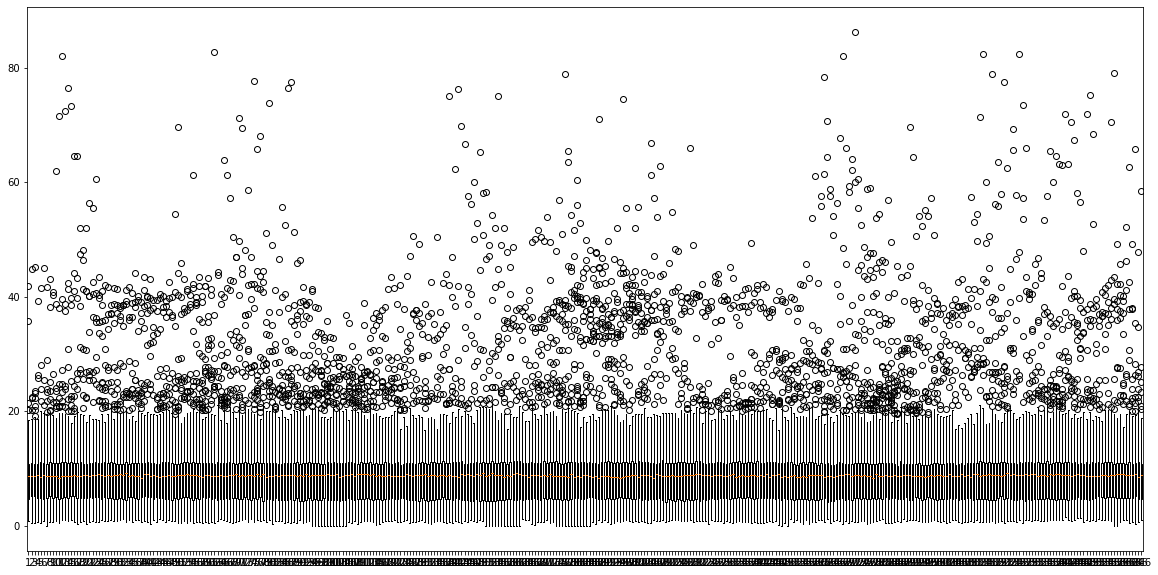

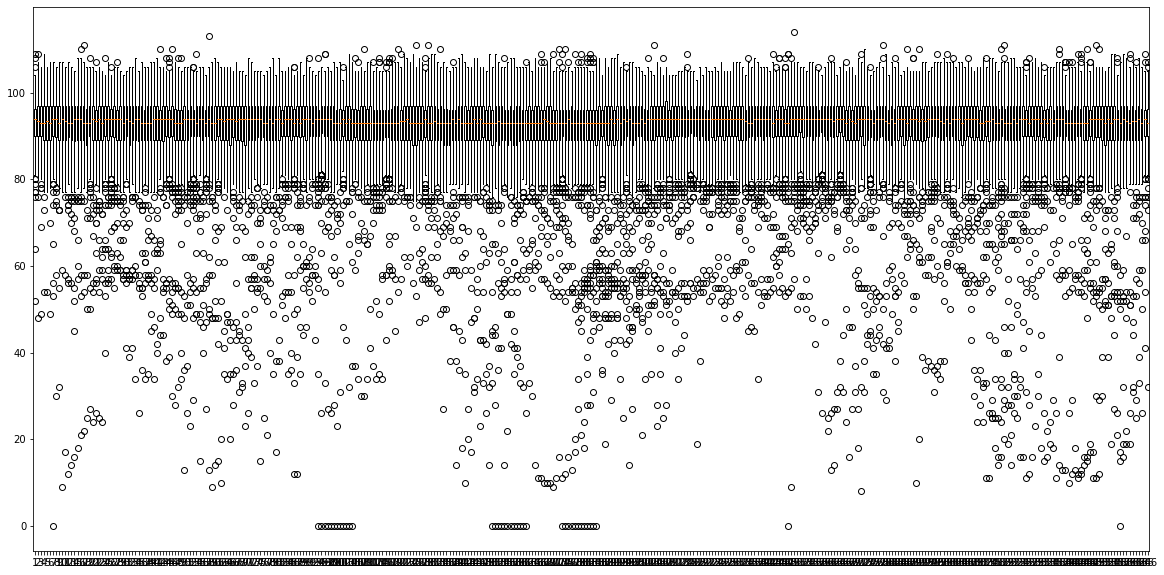

In [13]:
plotBoxContinous(data['Densidade[veic/km.faixa]'], savefig=True, filename='Density_boxplot_Daily.png')

plotBoxContinous(data['Velocidade[km/h]'])

# Plotting data

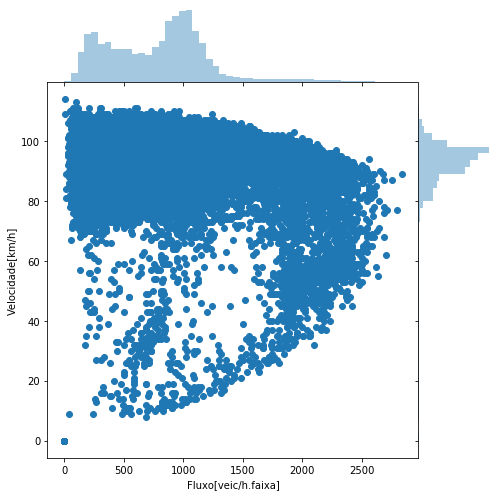

In [14]:
#sns.set(style='white')
g = sns.jointplot(data['Fluxo[veic/h.faixa]'], data['Velocidade[km/h]'], kind='scatter', height=7, space=0)

### Using Matplotlib

C:\Users\alcunha\AppData\Local\Continuum\miniconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


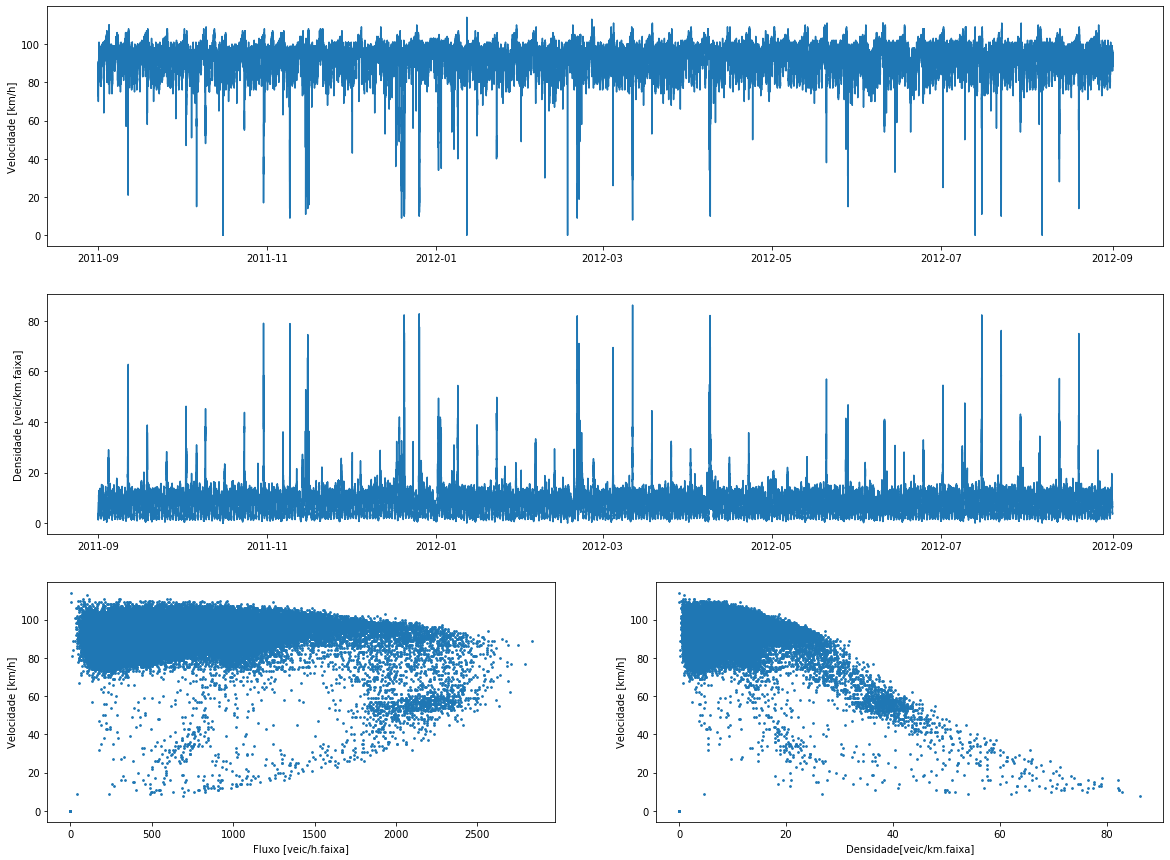

In [15]:
plt.figure(figsize=(20,15))

ax1 = plt.subplot(3,2,(1,2))
plt.plot(data['Velocidade[km/h]'])
ax1.set(ylabel = 'Velocidade [km/h]')

ax2=plt.subplot(3,2,(3,4))
plt.plot(data['Densidade[veic/km.faixa]'])
ax2.set(ylabel = 'Densidade [veic/km.faixa]')

ax3 = plt.subplot(3,2,5)
plt.scatter(data['Fluxo[veic/h.faixa]'], data['Velocidade[km/h]'], s=3)
ax3.set(xlabel='Fluxo [veic/h.faixa]', ylabel = 'Velocidade [km/h]')

ax4 = plt.subplot(3,2,6)
plt.scatter(data['Densidade[veic/km.faixa]'], data['Velocidade[km/h]'], s=3 )
ax4.set(xlabel='Densidade[veic/km.faixa]', ylabel='Velocidade [km/h]')

plt.show()

### Using Pandas

In [16]:
data.corr()

Fluxo[veic/h.faixa]  Velocidade[km/h]  \
Fluxo[veic/h.faixa]                  1.000000          0.069051   
Velocidade[km/h]                     0.069051          1.000000   
Densidade[veic/km.faixa]             0.888302         -0.278193   

                          Densidade[veic/km.faixa]  
Fluxo[veic/h.faixa]                       0.888302  
Velocidade[km/h]                         -0.278193  
Densidade[veic/km.faixa]                  1.000000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C3E4B92B38>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001C3E6F5C4E0>]], dtype=object)

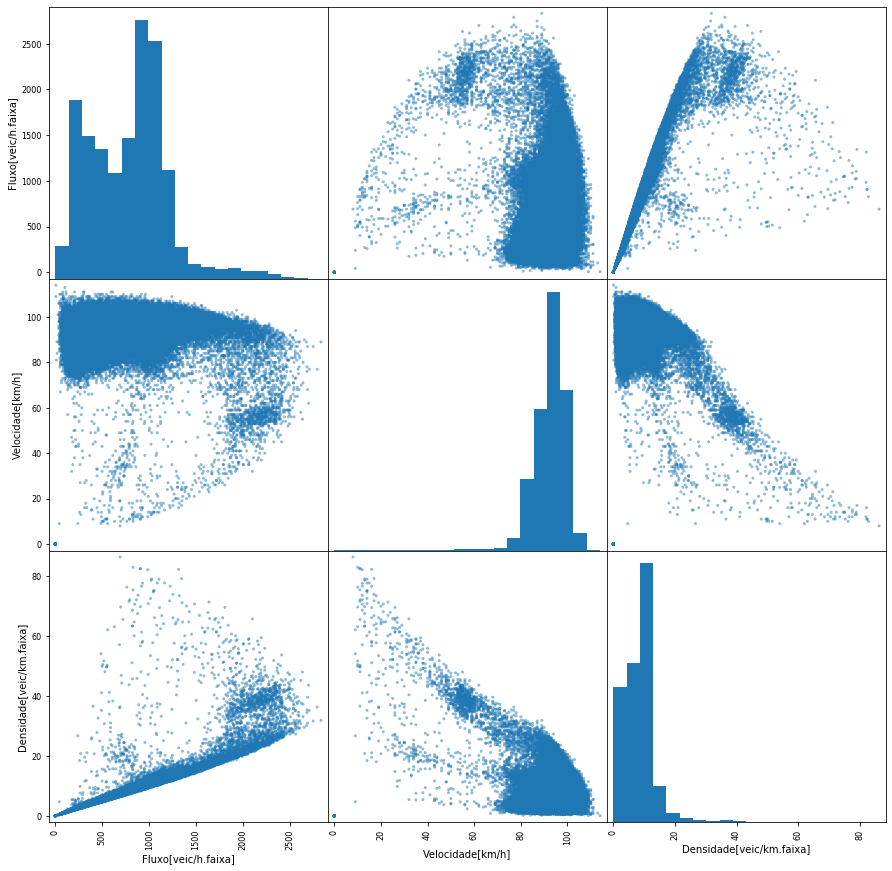

In [17]:
pd.plotting.scatter_matrix(data, figsize=(15,15), diagonal='hist', hist_kwds={'bins':20})

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C3E702B198>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001C3E7BEE4A8>], dtype=object)

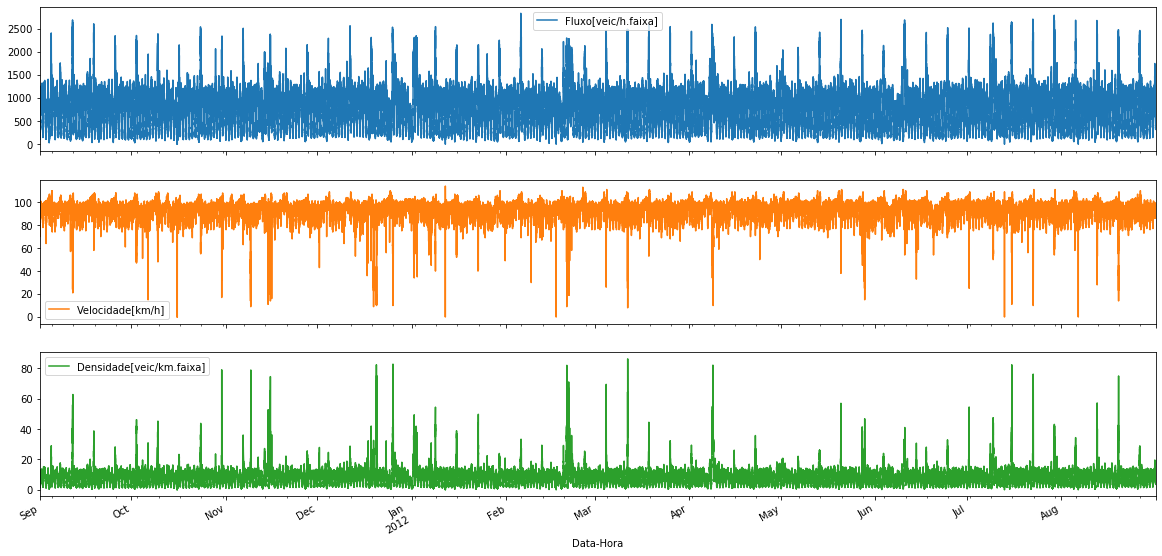

In [18]:
data.plot(subplots=True, figsize=(20,10))

### Others plotting tests

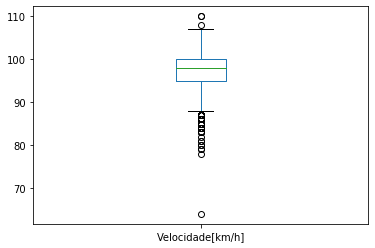

In [19]:
data['2011-09-03':'2011-09-04']['Velocidade[km/h]'].plot(kind='box')

Data-Hora
2011-09-30    AxesSubplot(0.125,0.125;0.775x0.755)
2011-10-31    AxesSubplot(0.125,0.125;0.775x0.755)
2011-11-30    AxesSubplot(0.125,0.125;0.775x0.755)
2011-12-31    AxesSubplot(0.125,0.125;0.775x0.755)
2012-01-31    AxesSubplot(0.125,0.125;0.775x0.755)
2012-02-29    AxesSubplot(0.125,0.125;0.775x0.755)
2012-03-31    AxesSubplot(0.125,0.125;0.775x0.755)
2012-04-30    AxesSubplot(0.125,0.125;0.775x0.755)
2012-05-31    AxesSubplot(0.125,0.125;0.775x0.755)
2012-06-30    AxesSubplot(0.125,0.125;0.775x0.755)
2012-07-31    AxesSubplot(0.125,0.125;0.775x0.755)
2012-08-31    AxesSubplot(0.125,0.125;0.775x0.755)
Freq: M, Name: Velocidade[km/h], dtype: object

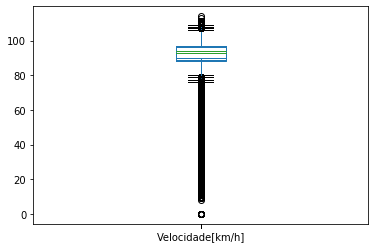

In [20]:
data['Velocidade[km/h]'].resample('M').plot(kind='box')

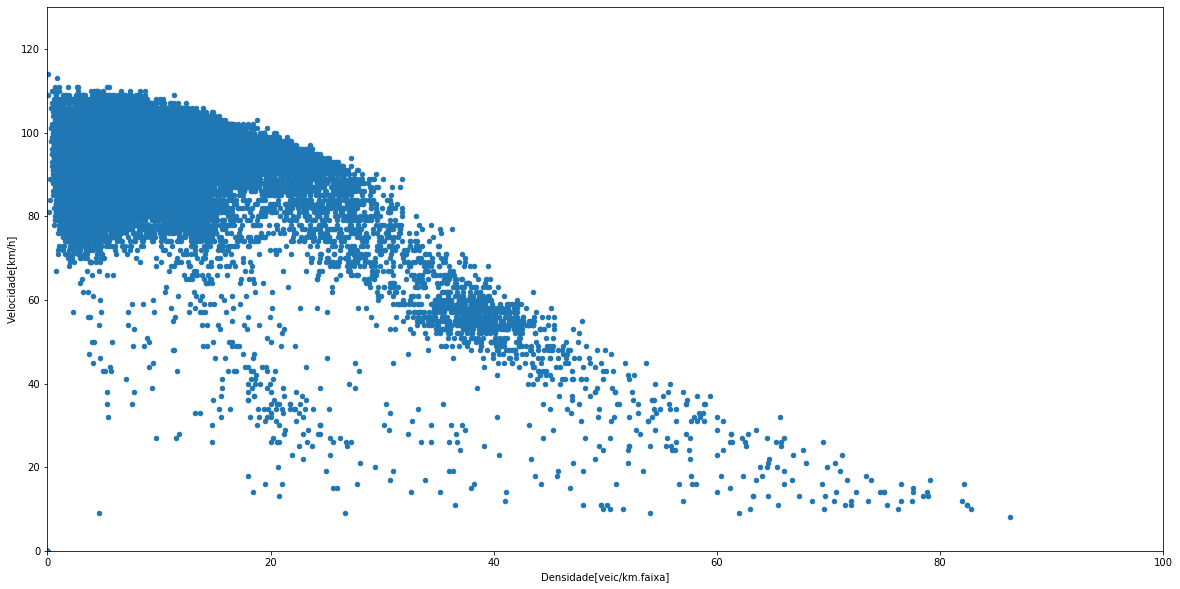

In [21]:
data.plot(x='Densidade[veic/km.faixa]',
          y='Velocidade[km/h]',
          kind='scatter',
          figsize=(20,10),
         xlim=(0,100),
         ylim=(0,130))

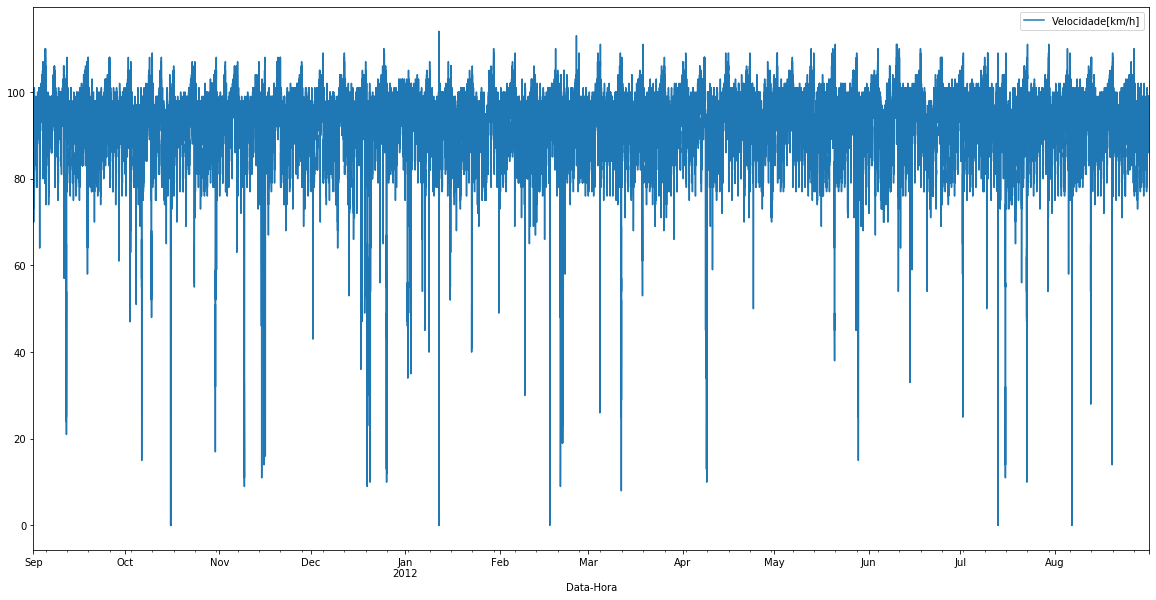

In [22]:
data.plot(y='Velocidade[km/h]',
          kind='line',
          figsize=(20,10))

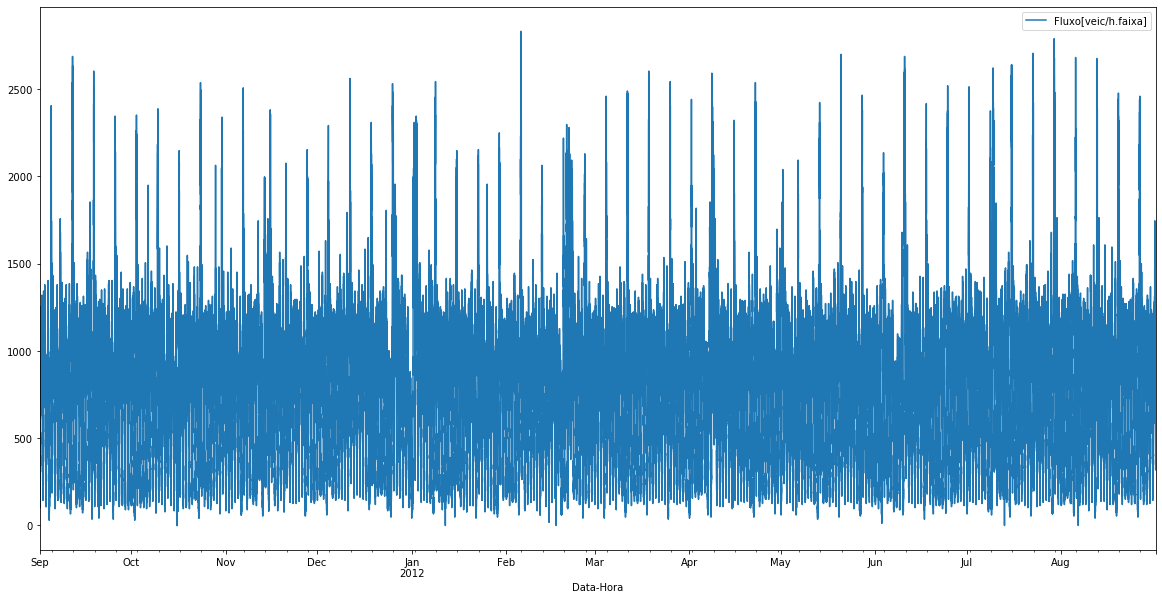

In [23]:
data.plot(y='Fluxo[veic/h.faixa]',
          kind='line',
          figsize=(20,10))

# Filtering Data Analysis

## Filtering 'Speed' - ALL DATA

In [24]:
data.describe()

Fluxo[veic/h.faixa]  Velocidade[km/h]  Densidade[veic/km.faixa]
count        105408.000000     105408.000000             105408.000000
mean            782.236566         92.168583                  8.622564
std             416.745635          8.061075                  5.570966
min               0.000000          0.000000                  0.000000
25%             426.000000         89.000000                  4.750000
50%             840.000000         94.000000                  8.848485
75%            1038.000000         97.000000                 11.032258
max            2832.000000        114.000000                 86.250000

60741
102792


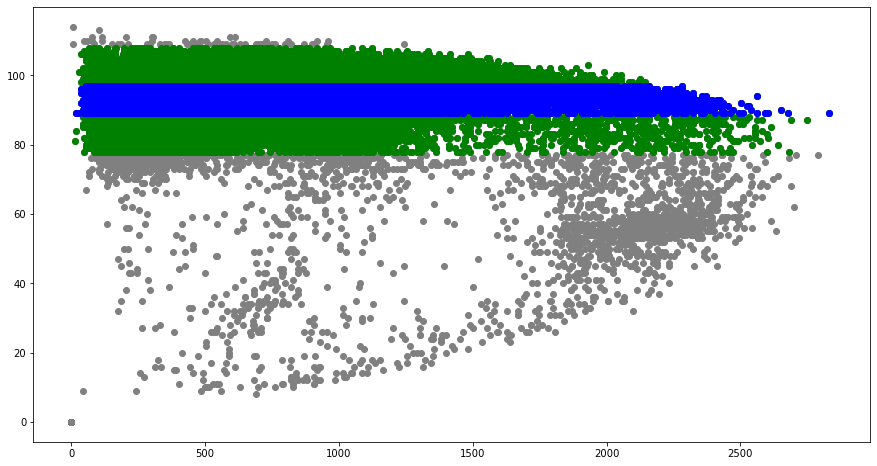

In [25]:
# Determine mask of Speed values with 50% of all data
mask50 = (data['Velocidade[km/h]'] >= data.quantile(.25)['Velocidade[km/h]']) & (data['Velocidade[km/h]'] <= data.quantile(.75)['Velocidade[km/h]'])
print(mask50.sum())

# Determine the whiskers (1.5 * IQR)
IQR = data.quantile(.75)['Velocidade[km/h]'] - data.quantile(.25)['Velocidade[km/h]']
maskIQR = ((data['Velocidade[km/h]'] > data.quantile(.25)['Velocidade[km/h]'] - 1.5 * IQR) & 
(data['Velocidade[km/h]'] < data.quantile(.75)['Velocidade[km/h]'] + 1.5 * IQR ) )
print(maskIQR.sum())

var = 'Fluxo[veic/h.faixa]'
#var = 'Densidade[veic/km.faixa]'

plt.figure(figsize = (15,8))
plt.scatter(data[var], data['Velocidade[km/h]'], color='grey') 
plt.scatter(data[maskIQR][var], data[maskIQR]['Velocidade[km/h]'], color='green')
plt.scatter(data[mask50][var], data[mask50]['Velocidade[km/h]'], color='blue')

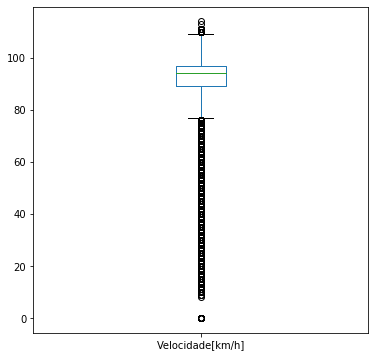

In [26]:
data['Velocidade[km/h]'].plot(kind='box', figsize=(6,6))

## Filtering 'Speed' - FOR EACH SPECIFIC PERIOD

In [27]:
# function to check specified quantile:
def in_qrange(ser, q):
    return ser.between(*ser.quantile(q=q))

def in_IQRrange(ser, dev=1.5):
    p25, p75 = ser.quantile([.25, .75])
    IQR = p75-p25
    return ser.between( p25 - dev * IQR, p75 + dev * IQR, inclusive = False)

58779
101032


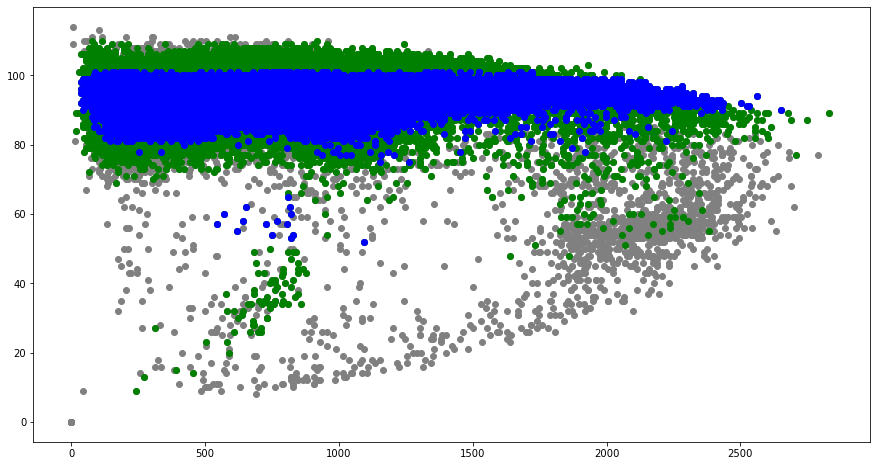

In [28]:
period = 'B'

# Determine mask of Speed values with 50% of each month
mask50 = data.resample(period)['Velocidade[km/h]'].transform(in_qrange, q=[.25, .75])
print(mask50.sum())

# Determine the whiskers (1.5 * IQR)
maskIQR = data.resample(period)['Velocidade[km/h]'].transform(in_IQRrange, dev=1.5)
print(maskIQR.sum())

var = 'Fluxo[veic/h.faixa]'
#var = 'Densidade[veic/km.faixa]'

plt.figure(figsize = (15,8))
plt.scatter(data[var], data['Velocidade[km/h]'], color='grey' ) 
plt.scatter(data[maskIQR][var], data[maskIQR]['Velocidade[km/h]'], color='green')
plt.scatter(data[mask50][var], data[mask50]['Velocidade[km/h]'], color='blue')

In [29]:
#data.groupby(by=pd.Grouper(freq='M')).plot(y='Velocidade[km/h]',kind='box')
def plotBoxPlotFreq(df, freq='W', var='Velocidade[km/h]'):
    dt = df.copy()
    dt['status'] = 0
    g = dt.resample(freq)
    idx = 0
    for v in g.indices.values():
        idx += 1
        dt['status'][v[0]:v[-1]] = idx

    mask = dt['status'] > 0
    dt[mask].boxplot(column=var, by='status', figsize=(20,6))

C:\Users\alcunha\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


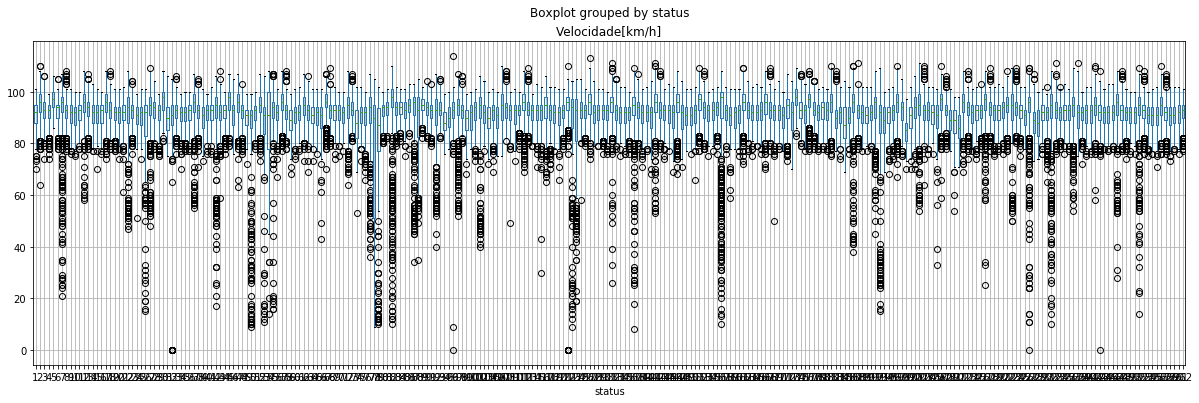

In [30]:
plotBoxPlotFreq(data, freq=period)

DatetimeIndex(['2011-09-01 00:00:00', '2011-09-01 00:05:00',
               '2011-09-01 00:10:00', '2011-09-01 00:15:00',
               '2011-09-01 00:20:00', '2011-09-01 00:25:00',
               '2011-09-01 00:30:00', '2011-09-01 00:35:00',
               '2011-09-01 00:40:00', '2011-09-01 00:45:00',
               ...
               '2012-08-31 23:10:00', '2012-08-31 23:15:00',
               '2012-08-31 23:20:00', '2012-08-31 23:25:00',
               '2012-08-31 23:30:00', '2012-08-31 23:35:00',
               '2012-08-31 23:40:00', '2012-08-31 23:45:00',
               '2012-08-31 23:50:00', '2012-08-31 23:55:00'],
              dtype='datetime64[ns]', name='Data-Hora', length=105408, freq=None)

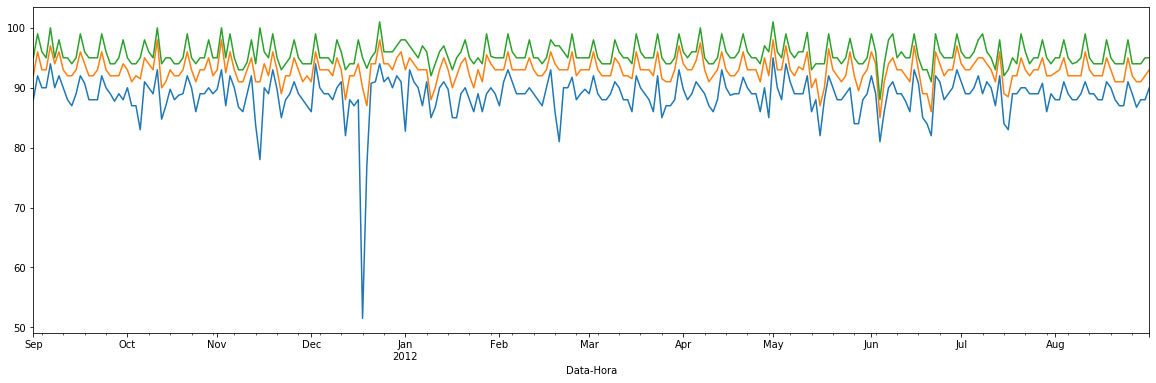

In [43]:
data['Velocidade[km/h]'].resample(period).quantile(.25).plot(figsize=(20,6))
data['Velocidade[km/h]'].resample(period).quantile(.5).plot()
#data['Velocidade[km/h]'].resample(period).mean().plot(marker='o')
data['Velocidade[km/h]'].resample(period).quantile(.75).plot()

## Selecting data from plot

In [42]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool
output_notebook()

Loading BokehJS ...

In [41]:
p = figure(title='Teste', x_axis_label='Fluxo', y_axis_label='Velocidade')
p.scatter(data['Fluxo[veic/h.faixa]'], data['Velocidade[km/h]'])
show(p)

In [53]:
var='density'

dates = data.index
source = ColumnDataSource(data=dict(date=dates, speed=data['Fluxo[veic/h.faixa]'], 
                                    flow=data['Fluxo[veic/h.faixa]'], 
                                    density=data['Densidade[veic/km.faixa]']))

p = figure(plot_height=300, plot_width=800, tools="xpan", toolbar_location=None,
           x_axis_type="datetime", x_axis_location="above",
           background_fill_color="#efefef", x_range=(dates[1000], dates[6000]))

p.line('date', var, source=source)
p.yaxis.axis_label = var

select = figure(title="Drag the middle and edges of the selection box to change the range above",
                plot_height=130, plot_width=800, y_range=p.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

range_tool = RangeTool(x_range=p.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

select.line('date', var, source=source)
select.ygrid.grid_line_color = None
select.add_tools(range_tool)
select.toolbar.active_multi = range_tool

show(column(p, select))

In [83]:
'''
try:
    from functools import lru_cache
except ImportError:
    # Python 2 does stdlib does not have lru_cache so let's just
    # create a dummy decorator to avoid crashing
    print ("WARNING: Cache for this example is available on Python 3 only.")
    def lru_cache():
        def dec(f):
            def _(*args, **kws):
                return f(*args, **kws)
            return _
        return dec
'''

import pandas as pd

from bokeh.io import curdoc, output_notebook
from bokeh.layouts import row, column
from bokeh.models import ColumnDataSource
from bokeh.models.widgets import PreText, Select
from bokeh.plotting import figure

output_notebook()

DEFAULT_TICKERS = ['FLOW', 'SPEED', 'DENSITY']


def nix(val, lst):
    return [x for x in lst if x != val]

#@lru_cache()
def load_ticker(ticker):
    fname = 'SP-280-Leste.csv'
    data = pd.read_csv(fname, header=None, sep=',')
    # Drop the column '0'
    data = data.drop(columns=0)

    # Rename columns
    data = data.rename(columns={0:"ID", 1:"date",2:"FLOW", 3:"SPEED" })

    # Calculate flow rate
    data["FLOW"] = data["FLOW"] * 60 / 5 / 2 # two lanes

    # Calculate Density
    data["DENSITY"] = data["FLOW"] / data['SPEED']

    # Convert to_datetime
    data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y %H:%M')

    #Date-time column index
    data = data.set_index('date')
    return pd.DataFrame({ticker: data[ticker], ticker+'_returns': data[ticker].diff()})
    

#@lru_cache()
def get_data(t1, t2):
    df1 = load_ticker(t1)
    df2 = load_ticker(t2)
    data = pd.concat([df1, df2], axis=1)
    data = data.dropna()
    data['t1'] = data[t1]
    data['t2'] = data[t2]
    data['t1_returns'] = data[t1+'_returns']
    data['t2_returns'] = data[t2+'_returns']
    
    print(data)
    return data

# set up widgets

stats = PreText(text='', width=500)
ticker1 = Select(value='SPEED', options=nix('FLOW', DEFAULT_TICKERS))
ticker2 = Select(value='FLOW', options=nix('SPEED', DEFAULT_TICKERS))

# set up plots

source = ColumnDataSource(data=dict(date=[], t1=[], t2=[], t1_returns=[], t2_returns=[]))
source_static = ColumnDataSource(data=dict(date=[], t1=[], t2=[], t1_returns=[], t2_returns=[]))
tools = 'pan,wheel_zoom,xbox_select,reset'

corr = figure(plot_width=350, plot_height=350,
              tools='pan,wheel_zoom,box_select,reset')
corr.circle('t1_returns', 't2_returns', size=2, source=source,
            selection_color="orange", alpha=0.6, nonselection_alpha=0.1, selection_alpha=0.4)

ts1 = figure(plot_width=900, plot_height=200, tools=tools, x_axis_type='datetime', active_drag="xbox_select")
ts1.line('date', 't1', source=source_static)
ts1.circle('date', 't1', size=1, source=source, color=None, selection_color="orange")

ts2 = figure(plot_width=900, plot_height=200, tools=tools, x_axis_type='datetime', active_drag="xbox_select")
ts2.x_range = ts1.x_range
ts2.line('date', 't2', source=source_static)
ts2.circle('date', 't2', size=1, source=source, color=None, selection_color="orange")

# set up callbacks

def ticker1_change(attrname, old, new):
    ticker2.options = nix(new, DEFAULT_TICKERS)
    update()

def ticker2_change(attrname, old, new):
    ticker1.options = nix(new, DEFAULT_TICKERS)
    update()

def update(selected=None):
    t1, t2 = ticker1.value, ticker2.value

    data = get_data(t1, t2)
    source.data = source.from_df(data[['t1', 't2', 't1_returns', 't2_returns']])
    source_static.data = source.data

    update_stats(data, t1, t2)

    corr.title.text = '%s returns vs. %s returns' % (t1, t2)
    ts1.title.text, ts2.title.text = t1, t2

def update_stats(data, t1, t2):
    stats.text = str(data[[t1, t2, t1+'_returns', t2+'_returns']].describe())

ticker1.on_change('value', ticker1_change)
ticker2.on_change('value', ticker2_change)

def selection_change(attrname, old, new):
    t1, t2 = ticker1.value, ticker2.value
    data = get_data(t1, t2)
    selected = source.selected.indices
    if selected:
        data = data.iloc[selected, :]
    update_stats(data, t1, t2)

source.selected.on_change('indices', selection_change)

# set up layout
widgets = column(ticker1, ticker2, stats)
main_row = row(corr, widgets)
series = column(ts1, ts2)
layout = column(main_row, series)

# initialize
update()

curdoc().add_root(layout)
curdoc().title = "Traffic Time-based Analysis"

Loading BokehJS ...

                     SPEED  SPEED_returns   FLOW  FLOW_returns    t1     t2  \
date                                                                          
2011-09-01 00:05:00   82.0           -7.0  288.0          66.0  82.0  288.0   
2011-09-01 00:10:00   85.0            3.0  156.0        -132.0  85.0  156.0   
2011-09-01 00:15:00   81.0           -4.0  282.0         126.0  81.0  282.0   
2011-09-01 00:20:00   82.0            1.0  312.0          30.0  82.0  312.0   
2011-09-01 00:25:00   90.0            8.0  222.0         -90.0  90.0  222.0   
2011-09-01 00:30:00   84.0           -6.0  126.0         -96.0  84.0  126.0   
2011-09-01 00:35:00   84.0            0.0  198.0          72.0  84.0  198.0   
2011-09-01 00:40:00   73.0          -11.0  108.0         -90.0  73.0  108.0   
2011-09-01 00:45:00   85.0           12.0  156.0          48.0  85.0  156.0   
2011-09-01 00:50:00   87.0            2.0  174.0          18.0  87.0  174.0   
2011-09-01 00:55:00   83.0           -4.0  180.0    